In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

import numpy as np
import pandas as pd 
import json

import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

from transformers import BertTokenizer, get_linear_schedule_with_warmup

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix

import random
import wandb

import sys
sys.path.append('/home/inaki/host_data')
import models
from utils import train_loop, evaluate, evaluate_kfold_ensemble
from CreateDataset import BertDataset, RobertaDataset

In [2]:
!cat ~/.local/share/jupyter/runtime/jpserver-1.json
# http://g2.etsisi.upm.es:8898/lab?token=9066d3036084fc4bc65c2d9ccc7a04ed693f1b1097554d30

{
  "base_url": "/",
  "hostname": "0.0.0.0",
  "password": false,
  "pid": 1,
  "port": 8888,
  "root_dir": "/home/inaki",
  "secure": false,
  "sock": "",
  "token": "9066d3036084fc4bc65c2d9ccc7a04ed693f1b1097554d30",
  "url": "http://cd06abb7cc92:8888/",
  "version": "2.14.0"
}

In [3]:
!nvidia-smi

Wed May 15 20:50:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                Off | 00000000:37:00.0 Off |                  Off |
| 34%   39C    P8              15W / 260W |      1MiB / 49152MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
########################################
#                Ideas                 #
########################################

# Data Augmentation

    # Otros metodos 
        # Easy methods
        #     Synonym Replacement  |  Random synonym Insertion   |   Random Swap   |    Random Deletion
        # Albumentation (libreria)
        # Libreria para muchos de estos métodos  -  NLPAug 
        

    # Aumentado sobre embedding
        # Añadir ruido gaussiano
        # Ruido adversial
        # MixUp  (mezclar embedding y su label en la proporcion dada por una funcion)
        
    # Consistency regularization ??
    

# TO DO tutorias
    # LoRa  (Low rank adaptation)      -    https://medium.com/@karkar.nizar/fine-tuning-bert-for-text-classification-with-lora-f12af7fa95e4

    # Probar Con modelos que ven masyusculas bert-base-cased y bert-large-cased

    # Within-task and in-domain further pre-training can significantly boost its performance
    
    # Seleccionar los mejores en validation y hacer un ensemble con ellos y evaluar test (sobre enfoque baseline)

    # k-fold contrastive

    # Remplazo de sinonimos
    
    # Tecnicas basicas de data aumentacion
        # Round Trip transltion (quizas guardar las traducciones)
        # Ruido gaussiano

    # Volver a probar aumentado de datos con llama3
        
    # Probar CLS en vez de Mean Pooling ?


# Probar otros modelos
    # XLNet
    # RoBERTa
    # Roberta covid    -   https://huggingface.co/sagteam/covid-twitter-xlm-roberta-large
    # DeBERTa


# ----------
    # Analizar matriz de confusion sobre baseline
    # Bert ajustado para mensajes de redes sociales (telegram)
    # investigar Equilibrado transformers
    
# Recently DONE



    
# DONE
    # implementar MixUp
    # Probar MixUp

    # Contrastive Loss
        # Implementar yo el contrastive learning.  Probar con vectores muy sencillos a mano. revisar detach. cambiar a torch.
        # Dividir entre numero de elementos en el batch ??
        # Revisar formula paper y mirar mi codigo
        # Ir aplicando a modo de prueba todos los pasos con un batch de vectores muy sencillos.
        # Añado SWAP. SCL en dos fases, primero solo con contrastive loss y luego con BCE

    # Añadir model.eval() en evaluate para que el dropout funcione adecuadamente en test
    # devolver los logits y no la prediccion (y cambiar el BCE por el de logits)
    # Añadir capa densa entre el bert y las neuronas de clasificacion



    # Investigar *Supervised Contrastive learning 
    # Traduir dataset español y probar
    # Aumentado de datos con llama3 

    # Guardar modelos para probar forma de ensembles
    # Baseline 10 folds sobre test, para tener 10 test como al probar 10 ensembles
    # Plotear distribucion de errores
    # implementar Predicciones 0, 1 o no lo se
    # Matriz de confusion
    # probar los k modelos sobre test
    # Guardar ultimo epoch de validacion, quitar MCC cada epoch, gaurdar media y desviacion del ultimo
    # Mirar si tiene emojis y traducirlos a texto (emojify)

    #  ¿¿¿ #os.environ["CUBLAS_WORKSPACE_CONFIG"]=":16:8" ???
       # ERROR  # torch.use_deterministic_algorithms(True)  
    # guardar los resultados weight and bias o ML flow
    # Intentar guardar el MCC de cada fold para poder sacar desviaciones
    # Guardar semilas.  La semilla es para que los datos sean los mismos.
    # MCC  poner etiquetas a 1 y 2  ¿¿¿ seguro ???
    # Arreglar docker
    # sacar 10% de datos del dataset como sanity-check 
    # split stratify   (sklearn viene)
    # cross validation (sklearn)

In [6]:
###############################
#       configuración         #
###############################

#  RobertaLargeCovidPooledOut #  RobertaLargePooledOutput  #  BertLargeCovidPooledOutput  #  BertBasePooledOutput
MODEL_NAME = "RobertaLargePooledOutput"
EVALUATE_FREQ = 'END' # 'EVERY_EPOCH' #  'END'

MAX_LENGTH = 512
HEAD_DROPOUT = 0
DATA_AUGMENTATION = [] #["Oversampling"] # '_es_into_en' # 'llama_aug'
FOLDS_NUM = 5

NUM_EPOCHS = 5
LEARNING_RATE = 2e-5
BATCH_SIZE = 16

LOSS_FN =  'cross_entropy' # 'cross_entropy' # 'supervised_contrastive' #  'MixUp'  # 'MixUp_SCL'

# SCL
temperature = 0.3  # temprature for contrastive loss
lam = 1  # lambda for loss
SWAP = 2
DECAY = 0

# MixUp
ALFA = 0.2

# Selección de modelos
SELECTION = 0.2


checkoint_folder = 'Ensemble_baseline'

datadir = "/home/inaki/host_data/dataset_oppositional/"
cuda_device = 0
wandb_project = 'Ensemble_baseline'    # 'BASELINE'  'Ensemble_baseline'  'trash'  'epoch_analysis'

In [7]:
# Cargamos los datasets de entrenamiento y test
train_en_dataset_path = datadir + "train_en_data.pth"
test_en_dataset_path = datadir + "test_en_data.pth"
train_es_dataset_path = datadir + "train_es_data.pth"
test_es_dataset_path = datadir + "test_es_data.pth"

# Dataset traducido por llama3 8B
train_es_translated_path = datadir + "train_es_translated_data.pth"

# creamos los datasets de test
if MODEL_NAME.startswith("Roberta"):
    X, y = torch.load(test_es_dataset_path)
    test_es_dataset = RobertaDataset(X, y)
    X, y = torch.load(test_en_dataset_path)
    test_en_dataset = RobertaDataset(X, y)
elif MODEL_NAME.startswith("Bert"):
    X, y = torch.load(test_es_dataset_path)
    test_es_dataset = BertDataset(X, y)
    X, y = torch.load(test_en_dataset_path)
    test_en_dataset = BertDataset(X, y)


#Creamos dataloader de test
test_en_dataloader = DataLoader(test_en_dataset, batch_size=BATCH_SIZE, shuffle=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
##################################
#     Weigths and bias Login    #
##################################
# MY API KEY
#    240062b42b3367d962eecb38802f856b41245735
wandb.login(key="240062b42b3367d962eecb38802f856b41245735")

for i in range(10):
    print(f"experimento {i}:")
    #####################
    #  Reproducibilidad #
    #####################
    SEED = random.randint(0,10000)
    print(f"seed: {SEED}")
    # fuente  -  https://pytorch.org/docs/stable/notes/randomness.html
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True


    ######################################
    #          K-FOLD TRAIN LOOP         #
    ######################################

    # CROSS VALIDATION LOOP
    X, y = torch.load(train_en_dataset_path)
    X = np.array(X)
    y = np.array(y)

    if "_es_into_en" in DATA_AUGMENTATION:
        X_tr, y_tr = torch.load(train_es_translated_path)
        X_tr, y_tr = np.array(X_tr), np.array(y_tr)

    if "llama_aug" in DATA_AUGMENTATION:
        X_aug, y_aug = torch.load(datadir + "train_en_data_AUG_1-2.pth")
        X_aug, y_aug = np.array(X_aug), np.array(y_aug)


    skf = StratifiedKFold(n_splits=FOLDS_NUM, shuffle=True, random_state=42)

    k_test_outputs = []
    # Loop over the folds
    for fold_idx, (train_index, val_index) in enumerate(skf.split(X, y)):
        print(f"fold {fold_idx + 1}")
        
        # Weigths and bias init
        config = {
        "MAX_LENGTH": MAX_LENGTH,
        "HEAD_DROPOUT": HEAD_DROPOUT,
        "DATA_AUGMENTATION": DATA_AUGMENTATION,
        "FOLDS_NUM": FOLDS_NUM,
        "NUM_EPOCHS": NUM_EPOCHS,
        "LEARNING_RATE": LEARNING_RATE,
        "BATCH_SIZE": BATCH_SIZE,
        "FOLD_IDX": fold_idx,
        "DATA_AUGMENTATION": DATA_AUGMENTATION,
        "LOSS_FN": LOSS_FN,
        "SEED": SEED
        }
        GROUP = f"{MODEL_NAME}_{HEAD_DROPOUT}_{BATCH_SIZE}_{LEARNING_RATE}_{DATA_AUGMENTATION}_{LOSS_FN}"
        if LOSS_FN == 'supervised_contrastive' or LOSS_FN == 'MixUp_SCL':
            GROUP += f"_{temperature}"
            if DECAY != 0:
                GROUP += f"_dec-{DECAY}"
            if SWAP != 0:
                GROUP += f"_swap-{SWAP}"
            else:
                GROUP += f"_lam-{lam}"
        if LOSS_FN == 'MixUp' or LOSS_FN == 'MixUp_SCL':
            GROUP += f"_alfa-{ALFA}"
        wandb.init(project=wandb_project, group=GROUP, config=config)
        
        # Create the fold-specific train and validation sets
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # mapeo indices de los originales a sus aumentaciones 1 a 2
        if "llama_aug" in DATA_AUGMENTATION:
            train_aug_idx = []
            for idx in train_index:
                train_aug_idx += [idx*2, idx*2 +1]  # Esto esta hardcodeado a que sea 1 a 2
            X_aug_train, y_aug_train = X_aug[train_aug_idx], y_aug[train_aug_idx]
            # Concateno los datos aumentados
            X_train_fold = np.concatenate((X_train_fold, X_aug_train))
            y_train_fold = np.concatenate((y_train_fold, y_aug_train))

        #El de entrenamiento le añado el dataset traducido
        if "_es_into_en" in DATA_AUGMENTATION:
            X_train_fold = np.concatenate((X_train_fold, X_tr))
            y_train_fold = np.concatenate((y_train_fold, y_tr))

        # MixUP
        if LOSS_FN == 'MixUp' or LOSS_FN == 'MixUp_SCL':
            # separamos el dataset entre positivos y negativos.  
            ###  ¡¡  OJO estamos usando tambien el aumentado de llama y el traducido  !!
            positive = BertDataset(X_train_fold[y_train_fold == 1], y_train_fold[y_train_fold == 1])
            negative = BertDataset(X_train_fold[y_train_fold == 0], y_train_fold[y_train_fold == 0])
            
        else:
            positive = None
            negative = None

        # Creo los datasets de entrenamiento y validación.
        # si el MODEL_NAME empieza por Roberta, uso el tokenizer de Roberta, si no, uso el de Bert
        if MODEL_NAME.startswith("Roberta"):
            train_en_dataset = RobertaDataset(X_train_fold, y_train_fold)
            val_en_dataset = RobertaDataset(X_val_fold, y_val_fold)
        elif MODEL_NAME.startswith("Bert"):
            train_en_dataset = BertDataset(X_train_fold, y_train_fold)
            val_en_dataset = BertDataset(X_val_fold, y_val_fold)
        
        # Create the train dataloader with a random oversampling of the minority class
        if "Oversampling" in DATA_AUGMENTATION:
            # Oversampling Train Dataloader
            labels = [sample[2] for sample in train_en_dataset]
            class_counts = torch.bincount(torch.tensor(labels))
            class_weights = 1.0 / class_counts.float()

            weights = [class_weights[label] for label in labels]
            sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_en_dataset), replacement=True)
            train_en_dataloader = DataLoader(train_en_dataset, sampler=sampler, batch_size=BATCH_SIZE)
            print(f"Oversampling")
        else:
            print(f"No Oversampling")
            train_en_dataloader = DataLoader(train_en_dataset, batch_size=BATCH_SIZE, shuffle=True)
            
        val_en_dataloader = DataLoader(val_en_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        # Instanciamos el modelo cuya clase viene dada por la variable MODEL_NAME
        # Obtén la referencia a la clase del módulo models
        ModelClass = getattr(models, MODEL_NAME)
        model = ModelClass(dropout_prob=HEAD_DROPOUT)
        
        device = torch.device(f"cuda:{cuda_device}" if torch.cuda.is_available() else "cpu")
        print(device)
        model.to(device)
        
        # Paralelizamos el modelo si hay mas de una GPU
        if torch.cuda.device_count() > 2:
            model = nn.DataParallel(model, device_ids=[1, 2])
            model.to(device)
            
        # Define your loss function (binary cross-entropy in this case)
        criterion = nn.BCELoss()
          
        # Activamos todas las capas
        for param in model.parameters():
            param.requires_grad = True
        
        # Contmaos los parametros entrenables
        print(f"total params: {sum(p.numel() for p in model.parameters())} trainble params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
        

        # Define your optimizer
        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
        
        # Define your learning rate scheduler
        total_steps = len(train_en_dataloader) * NUM_EPOCHS
        warmup_steps = int(total_steps * 0.1)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
        
        # debug pytorch version of contrastive loss
        # from utils import test_contrastive_loss
        #test_contrastive_loss(model, train_en_dataloader, temperature, lam, device)

        # Train the model
        train_loop(model, train_en_dataloader, test_en_dataloader, positive, negative, optimizer, scheduler, NUM_EPOCHS, temperature, lam, DECAY, LOSS_FN, device, SWAP, ALFA, EVALUATE_FREQ)

        # Evaluate the model
        _, validation_mcc = evaluate(model, val_en_dataloader, 0.5, device, val_or_test="Val")
        pred, test_mcc = evaluate(model, test_en_dataloader, 0.5, device, val_or_test="Test")
        k_test_outputs += [pred]
        
        # Save the model
        torch.save(model.state_dict(), f"/home/inaki/host_data/checkpoints/{checkoint_folder}/{GROUP}_exp-{i}_fold_{fold_idx}_Val-MCC_{validation_mcc}.pth")
    evaluate_kfold_ensemble(k_test_outputs, test_en_dataloader)
        
    # bB - Finalizamos el experimento
    wandb.finish()

wandb: Currently logged in as: inakitodc (inaki). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/inaki/.netrc


experimento 0:
seed: 2708
fold 1


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No Oversampling


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda:0
total params: 355360769 trainble params: 355360769


Epoch 1/5: 100%|██████████| 180/180 [05:07<00:00,  1.71s/batch, loss=0.522] 


Epoch 1, Average Train Loss: 0.46387203364736507


Epoch 2/5: 100%|██████████| 180/180 [05:06<00:00,  1.70s/batch, loss=0.135] 


Epoch 2, Average Train Loss: 0.20748315443181328


Epoch 3/5: 100%|██████████| 180/180 [05:06<00:00,  1.70s/batch, loss=0.0426] 


Epoch 3, Average Train Loss: 0.10555461299243486


Epoch 4/5: 100%|██████████| 180/180 [05:06<00:00,  1.70s/batch, loss=0.0547] 


Epoch 4, Average Train Loss: 0.03741425720250441


Epoch 5/5: 100%|██████████| 180/180 [05:06<00:00,  1.70s/batch, loss=0.00563]


Epoch 5, Average Train Loss: 0.015576410796751993
Val MCC 0.5 threshold:  0.8107
[[448  24]
 [ 37 211]]
Average Val Loss: 0.3460
Test MCC 0.5 threshold:  0.8216
[[249  13]
 [ 19 119]]
Average Test Loss: 0.2666
fold 2


Test_0.5_threshold_MCC,▁
Val_0.5_threshold_MCC,▁
Test_0.5_threshold_MCC,0.82161
Val_0.5_threshold_MCC,0.8107


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No Oversampling


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda:0
total params: 355360769 trainble params: 355360769


Epoch 1/5: 100%|██████████| 180/180 [05:08<00:00,  1.71s/batch, loss=0.311] 


Epoch 1, Average Train Loss: 0.5186827197257016


Epoch 2/5: 100%|██████████| 180/180 [05:06<00:00,  1.70s/batch, loss=0.141] 


Epoch 2, Average Train Loss: 0.2601796785679956


Epoch 3/5: 100%|██████████| 180/180 [05:06<00:00,  1.70s/batch, loss=0.103] 


Epoch 3, Average Train Loss: 0.15079038004494374


Epoch 4/5: 100%|██████████| 180/180 [05:06<00:00,  1.71s/batch, loss=0.122]  


Epoch 4, Average Train Loss: 0.07070061176911824


Epoch 5/5: 100%|██████████| 180/180 [05:06<00:00,  1.70s/batch, loss=0.0208] 


Epoch 5, Average Train Loss: 0.03335235768204762
Val MCC 0.5 threshold:  0.8233
[[449  23]
 [ 34 214]]
Average Val Loss: 0.2828
Test MCC 0.5 threshold:  0.8050
[[247  15]
 [ 20 118]]
Average Test Loss: 0.3016
fold 3


Test_0.5_threshold_MCC,▁
Val_0.5_threshold_MCC,▁
Test_0.5_threshold_MCC,0.80503
Val_0.5_threshold_MCC,0.82332


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No Oversampling


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda:0
total params: 355360769 trainble params: 355360769


Epoch 1/5: 100%|██████████| 180/180 [05:08<00:00,  1.71s/batch, loss=0.148] 


Epoch 1, Average Train Loss: 0.4734380390495062


Epoch 2/5: 100%|██████████| 180/180 [05:06<00:00,  1.70s/batch, loss=0.28]  


Epoch 2, Average Train Loss: 0.22430828999107083


Epoch 3/5: 100%|██████████| 180/180 [05:06<00:00,  1.70s/batch, loss=0.177]  


Epoch 3, Average Train Loss: 0.10642630711146113


Epoch 4/5: 100%|██████████| 180/180 [05:06<00:00,  1.70s/batch, loss=0.00222]


Epoch 4, Average Train Loss: 0.038097205822769965


Epoch 5/5: 100%|██████████| 180/180 [05:06<00:00,  1.70s/batch, loss=0.00263]


Epoch 5, Average Train Loss: 0.022198122992025067
Val MCC 0.5 threshold:  0.7954
[[444  28]
 [ 38 210]]
Average Val Loss: 0.3519
Test MCC 0.5 threshold:  0.8383
[[251  11]
 [ 18 120]]
Average Test Loss: 0.2938
fold 4


Test_0.5_threshold_MCC,▁
Val_0.5_threshold_MCC,▁
Test_0.5_threshold_MCC,0.83828
Val_0.5_threshold_MCC,0.79544


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No Oversampling


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda:0
total params: 355360769 trainble params: 355360769


Epoch 1/5: 100%|██████████| 180/180 [05:08<00:00,  1.71s/batch, loss=0.625]


Epoch 1, Average Train Loss: 0.5765644804471068


Epoch 2/5: 100%|██████████| 180/180 [05:06<00:00,  1.70s/batch, loss=0.171] 


Epoch 2, Average Train Loss: 0.3358575368920962


Epoch 3/5: 100%|██████████| 180/180 [05:06<00:00,  1.70s/batch, loss=0.0751]


Epoch 3, Average Train Loss: 0.23976188231673506


Epoch 4/5: 100%|██████████| 180/180 [05:06<00:00,  1.70s/batch, loss=0.379] 


Epoch 4, Average Train Loss: 0.16185831783546342


Epoch 5/5: 100%|██████████| 180/180 [05:06<00:00,  1.70s/batch, loss=0.35]  


Epoch 5, Average Train Loss: 0.11424906240879662
Val MCC 0.5 threshold:  0.8366
[[447  25]
 [ 28 220]]
Average Val Loss: 0.2483
Test MCC 0.5 threshold:  0.8044
[[249  13]
 [ 22 116]]
Average Test Loss: 0.2807
fold 5


Test_0.5_threshold_MCC,▁
Val_0.5_threshold_MCC,▁
Test_0.5_threshold_MCC,0.80439
Val_0.5_threshold_MCC,0.83657


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No Oversampling


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda:0
total params: 355360769 trainble params: 355360769


Epoch 1/5: 100%|██████████| 180/180 [05:08<00:00,  1.71s/batch, loss=0.468]


Epoch 1, Average Train Loss: 0.5281728137698438


Epoch 2/5:  22%|██▏       | 40/180 [01:08<03:58,  1.71s/batch, loss=0.433] 

In [ ]:
#### Bucle cargando todos los modelos BASELINE
baseline_test_outputs = []
device = torch.device(f"cuda:{cuda_device}" if torch.cuda.is_available() else "cpu")

# Filtramos los modelos que queremos evaluar
modelos = os.listdir("/home/inaki/host_data/checkpoints/Ensemble_baseline/")
modelos = [m for m in modelos if m.startswith('BertLargeCovidPooledOutput_0.0_16_2e-05_[]_cross_entropy')]
# modelos = [m for m in modelos if m.startswith(GROUP)]

for model_path in modelos:
    ModelClass = getattr(models, MODEL_NAME)
    model = ModelClass(dropout_prob=HEAD_DROPOUT)
    # Load the saved state dictionary into the initialized model
    
    state_dict = torch.load('/home/inaki/host_data/checkpoints/Ensemble_baseline/' + model_path)
    # Remove the 'module.' prefix from keys if present (esto es por ser un modelo paralelizado)
    if 'module.' in list(state_dict.keys())[0]:
        state_dict = {key[7:]: value for key, value in state_dict.items()}
    model.load_state_dict(state_dict)

    model.to(device)
    model.eval()
    baseline_test_outputs += [evaluate(model, test_en_dataloader, 0.5, device, val_or_test="Test")]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

,mcc,low,up
104,0.878551,0.49,0.55
105,0.878551,0.49,0.56
106,0.878551,0.49,0.57
114,0.878551,0.50,0.54
113,0.878551,0.50,0.53
116,0.878551,0.50,0.56
115,0.878551,0.50,0.55
117,0.878551,0.50,0.57
102,0.878551,0.49,0.53
103,0.878551,0.49,0.54


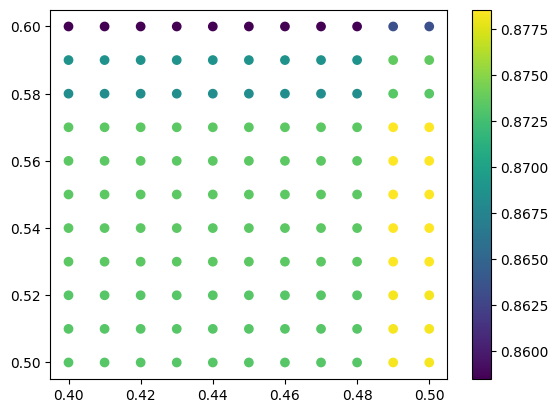

In [10]:
# Evaluamos el valor optimo para el threshold
test_true_labels = []
for data in test_en_dataloader:
    input_ids, attention_mask, labels, _ = data
    test_true_labels += labels.tolist()

all_mcc = []
threshold = []
low, up = [], []
test_outputs = np.array(baseline_test_outputs)
test_outputs = test_outputs.mean(axis=0)
for i in range(40, 51):
    for j in range(50, 61):
        test_mean_predictions = [0 if x < i/100 else (1 if x > j/100 else -1) for x in test_outputs]
        mcc = matthews_corrcoef(test_true_labels, test_mean_predictions)
        all_mcc += [mcc]
        low += [i/100]
        up += [j/100]
        # create a df with the results and sort by mcc

df = pd.DataFrame({'mcc':all_mcc, 'low':low, 'up':up})
df = df.sort_values('mcc', ascending=False)
# display all df
#pd.set_option('display.max_rows', None)
display(df.head(15))

# plot que representa en los ejes x e y los valores de low y up y en el eje z el mcc
plt.scatter(df['low'], df['up'], c=df['mcc'], cmap='viridis')
plt.colorbar()
plt.show()


In [11]:
evaluate_kfold_ensemble(baseline_test_outputs, test_en_dataloader)

test ensemble MCC 0.5 threshold: 0.8783


In [12]:
# Seleccion de los modelos que superan al % de SELECTION en validacion
l = [float(m.split("_")[-1][:-4]) for m in modelos]

# ordenamos de menor a mayor en una nueva lista
l_sorted = sorted(l)
threshold = l_sorted[int(len(l_sorted)*SELECTION)]
indices = [i for i, x in enumerate(l) if x > threshold]

# Filtramos los outpouts de los modelos que queremos ensamblar
test_outputs = np.array(baseline_test_outputs)
test_outputs = test_outputs[indices]

print(f"Antes de la seleccion del top {SELECTION} en validacion:")
evaluate_kfold_ensemble(baseline_test_outputs, test_en_dataloader)
print("Despues:")
evaluate_kfold_ensemble(test_outputs, test_en_dataloader)

['BertLargeCovidPooledOutput_0.0_16_2e-05_[]_cross_entropy_exp-4_fold_0.pth',
 'BertLargeCovidPooledOutput_0.0_16_2e-05_[]_cross_entropy_exp-5_fold_0.pth',
 'BertLargeCovidPooledOutput_0.0_16_2e-05_[]_cross_entropy_exp-5_fold_3.pth',
 'BertLargeCovidPooledOutput_0.0_16_2e-05_[]_cross_entropy_exp-9_fold_1.pth',
 'BertLargeCovidPooledOutput_0.0_16_2e-05_[]_cross_entropy_exp-1_fold_1.pth',
 'BertLargeCovidPooledOutput_0.0_16_2e-05_[]_cross_entropy_exp-2_fold_0.pth',
 'BertLargeCovidPooledOutput_0.0_16_2e-05_[]_cross_entropy_exp-6_fold_4.pth',
 'BertLargeCovidPooledOutput_0.0_16_2e-05_[]_cross_entropy_exp-8_fold_2.pth',
 'BertLargeCovidPooledOutput_0.0_16_2e-05_[]_cross_entropy_exp-1_fold_0.pth',
 'BertLargeCovidPooledOutput_0.0_16_2e-05_[]_cross_entropy_exp-6_fold_3.pth',
 'BertLargeCovidPooledOutput_0.0_16_2e-05_[]_cross_entropy_exp-6_fold_1.pth',
 'BertLargeCovidPooledOutput_0.0_16_2e-05_[]_cross_entropy_exp-8_fold_3.pth',
 'BertLargeCovidPooledOutput_0.0_16_2e-05_[]_cross_entropy_exp-5

In [ ]:
from IPython.display import display_html
display_html("<script>Jupyter.notebook.kernel.restart()</script>", raw=True)